In [1]:
import os
import os.path
import itertools
import pandas as pd

# STATISTICS TEST:http://sphweb.bumc.bu.edu/otlt/mph-modules/bs/bs704_nonparametric/bs704_nonparametric2.html

def get_patient_id(dirpath):
    dircomp = dirpath.split('_')
    return dircomp[-1].split('\\')[0]

def get_region(filename):
    if 'difference' in filename:
        return 'M-H Difference'
    elif 'choriod' in filename:
        return 'Choriod'
    elif 'retina' in filename:
        return 'Retina'
    elif 'homogenous' in filename:
        return 'Homogenous'
    elif 'match' in filename:
        return 'Match points'

def pid_feature_ranking(filepath):
    '''
        Input: filepath - path to mutual*2eyes.txt
        Output: dictionary of multi-index dataframe where the key are pid
                multi-index is [region], and [denoise, feature, MD] as first and second levels, respectively
    '''
    patient_folders = []
    feature_ranks = dict()
    for (dirpath, dirnames, filenames) in os.walk(filepath):
        #print('{}\n\t{}\n\t{}\n\n'.format(dirpath, dirnames, filenames))
        
        fileexist = False
        for f in filenames: 
            if 'mutual' and '2eyes' in f: 
                fileexist = True
                break
                    
        if dirnames and '2017' in dirnames[0]:
            patient_folders = dirnames
            #print(dirnames)
        elif fileexist: 
            pid = get_patient_id(dirpath)
            #print(pid)
            multiple_dataframes = []
            for fidx in range(0,len(filenames)):
                fname, file_extension = os.path.splitext(filenames[fidx])
                if (file_extension != '.txt') or ('mutual' and '2eyes' not in fname): continue
                #print('\t{} {}'.format(file_extension, filenames[fidx]))
                file = os.path.join(dirpath, filenames[fidx])
                region = get_region(file)
                data = pd.read_csv(file)
                data.columns = pd.MultiIndex.from_product([[region], data.columns])
                multiple_dataframes.append(data)
            if fidx == len(filenames)-1:
                if pid not in feature_ranks: 
                    feature_ranks[pid] = pd.concat(multiple_dataframes, axis = 1)
                    #print(pid)
    return feature_ranks, patient_folders

In [2]:
def feature_name_parts(featurename):
    cpos = [pos for pos in range(0, len(featurename)) if featurename[pos].isdigit()]
    element = int(''.join(featurename[cpos[0]:]))
    name = featurename[:cpos[0]]
    #print('F:{}, E:{}, N:{}, P:{}'.format(featurename, element,name,cpos))
    return name, element

def unpack_featurename(dataframe, reserved_column = ['MD']):
    '''
        dataframe: after selecting pid, type of md or region, grouped by and get group denoise method
        feature_ranks['cc0008']['M-H Difference'].groupby('Denoise').get_group('BM3D')
        reserved_column: list of columns e.g., ['MD']
    '''
    unpacked_dataframe = pd.DataFrame(dataframe, index = dataframe.index, columns=reserved_column)
    unpacked_dataframe['Feature'], unpacked_dataframe['Element'] = \
                 zip(*dataframe['Feature'].apply(lambda x: feature_name_parts(x)) )
    return unpacked_dataframe
    
def get_md_per_feature_element(dataframe, feature_types = ['MIND', 'AG', 'CHO', 'COC', 'RL']):
    '''Get dictionary of dictionary where the key is feature names 
       and the value is a internal dictionary of element number (key) and its MD '''
    '''
    Input dataframe of features computed in specific region (or difference between Match points and Homogenous region) 
             and using specific denoising method
    '''    
    feature_mds = dict()
    for ftype in feature_types:
        specific_feature_df = dataframe.groupby('Feature').get_group(ftype)
        specific_feature_md = dict()
        for index, row in specific_feature_df.iterrows():
            specific_feature_md[int(row['Element'])] = float(row['MD'])
        feature_mds[ftype] = specific_feature_md
    return feature_mds

def get_fixed_patient_region_features(feature_ranks, patient, region, feature_types = ['MIND', 'AG', 'CHO', 'COC', 'RL']):
    
    '''
        denoised_features: dictionary where keys are the denoising methods and values are dictionary from
        get_md_per_feature_element
    '''
    denoised_features = dict()
    bm3d_feature_df = feature_ranks[patient][region].groupby('Denoise').get_group('BM3D')
    bm3d_dataframe = unpack_featurename(bm3d_feature_df)
    denoised_features['BM3D'] = get_md_per_feature_element(bm3d_dataframe, feature_types)

    fnlm_feature_df = feature_ranks[patient][region].groupby('Denoise').get_group('FNLM')
    fnlm_dataframe = unpack_featurename(fnlm_feature_df)
    denoised_features['FNLM'] = get_md_per_feature_element(fnlm_dataframe, feature_types)

    none_feature_df = feature_ranks[patient][region].groupby('Denoise').get_group('None')
    none_dataframe = unpack_featurename(none_feature_df)
    denoised_features['None'] = get_md_per_feature_element(none_dataframe, feature_types)
    
    return denoised_features

def get_patient_folder(pid, patient_folders, filepath):
    for folder in patient_folders: 
        if pid in folder: 
            patient_folder = os.path.join(filepath, folder)
    return patient_folder   


In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plt_denoise_w_feature_md(denoised_features, yrange = [0, 1], font_size = 12, font_family = 'Arial', \
            feature_types = ['MIND', 'AG','CHO', 'COC', 'RL'], denoise_methods = ['None', 'BM3D', 'FNLM']):
    
    sns.set(style="white", color_codes=True)
    min_md = dict()
    
    font_name = {'fontname':font_family}
    gray = [0.7]*3
    colormap = [(0,0,1), (0,1,0), (0,0,0)]
    marker_shapes = ['o', 's', '^']
    
    ystep = (yrange[1]-yrange[0])/2
    ymax = yrange[1]+ystep
    
    for ftype in feature_types:
        
        fig = plt.figure()
        ax = plt.axes()        
        
        number_of_elements = 0
        for dn in range(0, len(denoise_methods)):
            denoise = denoise_methods[dn]
            features_md = denoised_features[denoise][ftype]
            number_of_elements = len(features_md.keys())
            sorted_features_md = dict((element, md) for (element, md) in sorted(features_md.items()))            
            x = list(sorted_features_md.keys())
            y = list(sorted_features_md.values())
            min_md[ftype] = (dn, min(y))
            plt.plot(x, y, color=colormap[dn], linestyle='None', marker=marker_shapes[dn], markerfacecolor = 'w',\
                     markeredgecolor=colormap[dn], markeredgewidth = 1.5, markersize  = 10.0, label=denoise) 
        xrange = [0, number_of_elements+1]
        #ax.plot(xrange, [1]*2, color = gray, linestyle=':', linewidth = 1.5)
        ax.axhline(y=0, color=gray, linestyle=':', linewidth = 0.8)
        plt.xlim(xrange[0], xrange[1])
        plt.ylim(yrange[0], yrange[1]);
        plt.xticks(x, **font_name, fontsize=font_size)
        start, end = ax.get_ylim()
        ax.yaxis.set_ticks(np.arange(start, ymax, ystep))
        plt.yticks(fontname = font_family, fontsize=font_size)  
        plt.xlabel(ftype, **font_name, fontsize=font_size)
        plt.ylabel("Mutual Descriptiveness", **font_name, fontsize=font_size+1);        
        plt.margins(0.2)
        plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)
        l = plt.legend();
        plt.setp(l.texts, family=font_family,fontsize=font_size)
        plt.tight_layout()
        
    return min_md


In [4]:
   
def sns_plot_denoise_w_feature_md(denoised_features, yrange = [0, 1],  font_size = 12, font_family = 'Arial', \
        patient_folder = None, region = None, feature_types = ['MIND', 'AG', 'CHO', 'COC', 'RL'],\
        denoise_methods = ['None', 'BM3D', 'FNLM']):
    

    sns.set('paper', style="white", color_codes=True, font='Arial', font_scale = 1)
    min_md = dict()
    
    font_name = {'fontname':font_family}
    gray = [0.7]*3
    colormap = [(0,0,1), (0,0,0), (0,0.4,0)]
    marker_shapes = ['o', 's', '^']
    line_styles = [':', '-', '-.']
    marker_sizes = [40,40, 55]
    
    ystep = (yrange[1]-yrange[0])/2
    ymax = yrange[1]+ystep
    ymin = yrange[0]
    
    figw, figh = 16, 5
    fig, axes= plt.subplots(nrows = 1, ncols = len(feature_types), sharey=True, figsize=(figw, figh))
    plt.subplots_adjust(left=1/figw, right=1-1/figw, bottom=1/figh, top=1-1/figh)   
    
    for fidx in range(0, len(feature_types)):
        
        ax = axes[fidx]
        ftype = feature_types[fidx]
        
        ax.axhline(y=0, color=gray, linestyle='--', linewidth = 1.5, alpha = 0.7)
        
        for dn in range(0, len(denoise_methods)):
            
            denoise = denoise_methods[dn]
            features_md = denoised_features[denoise][ftype]
            
            sorted_features_md = dict((element, md) for (element, md) in sorted(features_md.items()))            
            element = list(sorted_features_md.keys())
            md = list(sorted_features_md.values())
                
            d = {ftype : pd.Series(element),'Mutual Descriptiveness' : pd.Series(md)}
            df = pd.DataFrame(d)
            columns = [ftype, 'Mutual Descriptiveness']
            
            xrange = [0, len(element)+1]
            ax.set(xlim=(xrange[0], xrange[1]), ylim=(yrange[0], yrange[1]))
            
            sns.regplot(x=ftype, y="Mutual Descriptiveness", data=df, lowess  = True, order = 1,\
                        scatter_kws={"alpha":0.9,"s":marker_sizes[dn]}, \
                        line_kws={"alpha":0.5, 'linestyle':line_styles[dn], 'linewidth':2},\
                        color=colormap[dn], marker = marker_shapes[dn], label=denoise, ax = ax)
            
            
            min_md[ftype] = (dn, min(md))
        
        if(len(element) > 10):
            xticks = [element[i] for i in range(len(element)) if i %2 == 1 ]
        else:
            xticks = element
        ax.set_xticks(xticks)
        ax.set_xticklabels(xticks)
        ax.set_yticks(np.arange(ymin, ymax, ystep))
        ax.set_yticklabels(np.arange(ymin, ymax, ystep))
        
        if ftype == 'MIND':
            ftype = 'D-MIND'
        ax.set_xlabel('{} element numbers'.format(ftype), size = font_size,alpha=1.0, visible = False)
        plt.setp(ax.get_xticklabels(), visible=False)
        ax.set_ylabel("Median of mutual descriptiveness",size = font_size,alpha=1.0)
        plt.setp(ax.get_yticklabels(), visible=True)
        
        # Set the ticklabel size and color of the graph from here
        ax.tick_params(labelsize=14,labelcolor="black")  
        
        # legend stuff
        legend = ax.legend(loc = 'upper left', fontsize = font_size-3, labelspacing = 0.3,\
                    columnspacing=0.1, fancybox=True,shadow=False,title='Denoising')
        
        plt.setp(legend.get_title(),fontsize=font_size-3)

        
        fig.subplots_adjust(hspace=6)     
        
        plt.tight_layout()
        
    if patient_folder:
        image_file = patient_folder+'//denoising_'+region+'.png';
        fig.savefig(image_file, dpi=300)
            
    return min_md



In [5]:
import numpy as np
from scipy import stats
from itertools import combinations
from statsmodels.stats.multitest import multipletests
from statsmodels.stats.libqsturng import psturng
import warnings


def kw_dunn(groups, to_compare=None, alpha=0.05, method='bonf'):
    """
    https://gist.github.com/alimuldal/fbb19b73fa25423f02e8
    
    Kruskal-Wallis 1-way ANOVA with Dunn's multiple comparison test
    Arguments:
    ---------------
    groups: sequence
        arrays corresponding to k mutually independent samples from
        continuous populations
    to_compare: sequence
        tuples specifying the indices of pairs of groups to compare, e.g.
        [(0, 1), (0, 2)] would compare group 0 with 1 & 2. by default, all
        possible pairwise comparisons between groups are performed.
    alpha: float
        family-wise error rate used for correcting for multiple comparisons
        (see statsmodels.stats.multitest.multipletests for details)
    method: string
        method used to adjust p-values to account for multiple corrections (see
        statsmodels.stats.multitest.multipletests for options)
    Returns:
    ---------------
    H: float
        Kruskal-Wallis H-statistic
    p_omnibus: float
        p-value corresponding to the global null hypothesis that the medians of
        the groups are all equal
    Z_pairs: float array
        Z-scores computed for the absolute difference in mean ranks for each
        pairwise comparison
    p_corrected: float array
        corrected p-values for each pairwise comparison, corresponding to the
        null hypothesis that the pair of groups has equal medians. note that
        these are only meaningful if the global null hypothesis is rejected.
    reject: bool array
        True for pairs where the null hypothesis can be rejected for the given
        alpha
    Reference:
    ---------------
    Gibbons, J. D., & Chakraborti, S. (2011). Nonparametric Statistical
    Inference (5th ed., pp. 353-357). Boca Raton, FL: Chapman & Hall.
    """

    # omnibus test (K-W ANOVA)
    # -------------------------------------------------------------------------

    groups = [np.array(gg) for gg in groups]

    k = len(groups)

    n = np.array([len(gg) for gg in groups])
    if np.any(n < 5):
        warnings.warn("Sample sizes < 5 are not recommended (K-W test assumes "
                      "a chi square distribution)")

    allgroups = np.concatenate(groups)
    N = len(allgroups)
    ranked = stats.rankdata(allgroups)

    # correction factor for ties
    T = stats.tiecorrect(ranked)
    if T == 0:
        raise ValueError('All numbers are identical in kruskal')

    # sum of ranks for each group
    j = np.insert(np.cumsum(n), 0, 0)
    R = np.empty(k, dtype=np.float)
    for ii in range(k):
        R[ii] = ranked[j[ii]:j[ii + 1]].sum()

    # the Kruskal-Wallis H-statistic
    H = (12. / (N * (N + 1.))) * ((R ** 2.) / n).sum() - 3 * (N + 1)

    # apply correction factor for ties
    H /= T

    df_omnibus = k - 1
    p_omnibus = stats.chisqprob(H, df_omnibus)

    # multiple comparisons
    # -------------------------------------------------------------------------

    # by default we compare every possible pair of groups
    if to_compare is None:
        to_compare = tuple(combinations(range(k), 2))

    ncomp = len(to_compare)

    Z_pairs = np.empty(ncomp, dtype=np.float)
    p_uncorrected = np.empty(ncomp, dtype=np.float)
    Rmean = R / n

    for pp, (ii, jj) in enumerate(to_compare):

        # standardized score
        #Zij = (np.abs(Rmean[ii] - Rmean[jj]) /
               #np.sqrt((1. / 12.) * N * (N + 1) * (1. / n[ii] + 1. / n[jj]))
        #Z_pairs[pp] = Zij
        
        # standardized score
        ts3_ts = list(np.unique(allgroups, return_counts=True)[1])
        E_ts3_ts = sum([x**3 - x for x in ts3_ts if x>1])

        if sum([x>1 for x in ts3_ts]) > 0:
            warnings.warn("We see ties.")

            yi = np.abs(Rmean[ii] - Rmean[jj])
            theta10 = (N * (N + 1)) / 12
            theta11 =  E_ts3_ts / ( 12* (N - 1) )
            theta2 = (1 / n[ii] + 1 / n[jj])
            theta = np.sqrt( (theta10 - theta11) * theta2 )
            Zij = yi / theta
        else:
            Zij = (np.abs(Rmean[ii] - Rmean[jj]) /
                   np.sqrt((1. / 12.) * N * (N + 1) * (1. / n[ii] + 1. / n[jj])))

            
    # corresponding p-values obtained from upper quantiles of the standard
    # normal distribution
    p_uncorrected = stats.norm.sf(Z_pairs) * 2.

    # correction for multiple comparisons
    reject, p_corrected, alphac_sidak, alphac_bonf = multipletests(
        p_uncorrected, method=method
    )

    return H, p_omnibus, Z_pairs, p_corrected, reject

In [9]:
#http://sphweb.bumc.bu.edu/otlt/mph-modules/bs/bs704_nonparametric/bs704_nonparametric2.html

def kruskal_dun_posthoc(denoised_features, feature_types = ['MIND', 'AG', 'COC', 'RL', 'CHO'], \
                        denoise_methods = ['None', 'BM3D', 'FNLM']):
    
    compared_indices = []#[(i,j) for i in range(0, len(denoise_methods) for j in range(i+1, len(denoise_methods))]
    for i in range(0, len(denoise_methods)):
        for j in range(i+1, len(denoise_methods)):
            compared_indices.append((i,j))

    # columns for DataFrame stored stats results        
    df_index = ['H', 'p_omnibus']+\
            ['z_pairs'+str(compared_indices[i][0])+str(compared_indices[i][1]) for i in range(0, len(compared_indices))]+\
            ['p_corrected'+str(compared_indices[i][0])+str(compared_indices[i][1]) for i in range(0, len(compared_indices))]+\
            ['reject'+str(compared_indices[i][0])+str(compared_indices[i][1]) for i in range(0, len(compared_indices))]

    denoised_feature_stats = pd.DataFrame(index=df_index)
    for ftype in feature_types:
        groups= []
        for dnoise in denoise_methods:
            element_mds = denoised_features[dnoise][ftype]
            sorted_features_md = dict((element, md) for (element, md) in sorted(element_mds.items()))
            groups.append(list(sorted_features_md.values()))

        H, p_omnibus, Z_pairs, p_corrected, reject = kw_dunn(groups, compared_indices)
        data = [H, p_omnibus] + Z_pairs.tolist() + p_corrected.tolist() +reject.tolist()

        #denoised_feature_stats.assign(ftype=pd.Series(data, index=df_index).values)
        denoised_feature_stats.loc[:,ftype] = pd.Series(data, index=denoised_feature_stats.index)
    return denoised_feature_stats

def kruskal(denoised_features, feature_types = ['MIND', 'AG', 'COC', 'RL', 'CHO'], \
                        denoise_methods = ['None', 'BM3D', 'FNLM']):

    # https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.kruskal.html
    
    # columns for DataFrame stored stats results        
    df_index = ['H', 'p_value']
    denoised_feature_stats = pd.DataFrame(index=df_index)
    
    for ftype in feature_types:
        reference_samples = []
        for dindx in range(0, len(denoise_methods)):
            dnoise = denoise_methods[dindx]
            element_mds = denoised_features[dnoise][ftype]
            sorted_features_md = dict((element, md) for (element, md) in sorted(element_mds.items()))            
            if dindx == 0:
                reference_samples = list(sorted_features_md.values())
            else:
                observed_samples = list(sorted_features_md.values())
                H, pvalue = stats.kruskal(reference_samples, observed_samples)
                denoised_feature_stats.loc[:,ftype] = pd.Series([H, pvalue], index=denoised_feature_stats.index)
                #denoised_feature_stats.assign(ftype=pd.Series([H, pvalue], index=df_index).values)
    return denoised_feature_stats

def wilcoxon(denoised_features, feature_types = ['MIND', 'AG', 'COC', 'RL', 'CHO'], \
                        denoise_methods = ['None', 'BM3D', 'FNLM']):

    #https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.wilcoxon.html
    
    # columns for DataFrame stored stats results        
    df_index = ['T', 'p_value']
    denoised_feature_stats = pd.DataFrame(index=df_index)
    
    for ftype in feature_types:
        reference_samples = []
        for dindx in range(0, len(denoise_methods)):
            dnoise = denoise_methods[dindx]
            element_mds = denoised_features[dnoise][ftype]
            sorted_features_md = dict((element, md) for (element, md) in sorted(element_mds.items()))            
            if dindx == 0:
                reference_samples = list(sorted_features_md.values())
            else:
                observed_samples = list(sorted_features_md.values())
                T, pvalue = stats.wilcoxon(reference_samples, observed_samples)
                denoised_feature_stats.loc[:,ftype] = pd.Series([T, pvalue], index=denoised_feature_stats.index)
    return denoised_feature_stats

def ttest(denoised_features, feature_types = ['MIND', 'AG', 'COC', 'RL', 'CHO'], \
                        denoise_methods = ['None', 'BM3D', 'FNLM']):

    #https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.wilcoxon.html
    
    # columns for DataFrame stored stats results        
    df_index = ['T', 'p_value']
    denoised_feature_stats = pd.DataFrame(index=df_index)
    
    for ftype in feature_types:
        reference_samples = []
        for dindx in range(0, len(denoise_methods)):
            dnoise = denoise_methods[dindx]
            element_mds = denoised_features[dnoise][ftype]
            sorted_features_md = dict((element, md) for (element, md) in sorted(element_mds.items()))            
            if dindx == 0:
                reference_samples = list(sorted_features_md.values())
            else:
                observed_samples = list(sorted_features_md.values())
                T, pvalue = stats.ttest_ind(reference_samples, observed_samples,equal_var=True)
                denoised_feature_stats.loc[:,ftype] = pd.Series([T, pvalue], index=denoised_feature_stats.index)
    return denoised_feature_stats

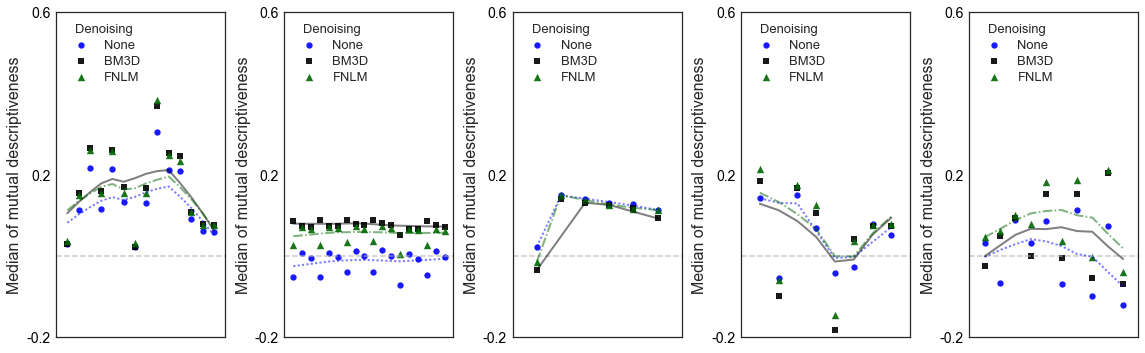

In [10]:
# plot parameters

feature_types = ['MIND', 'AG','CHO','COC', 'RL']
denoise_methods = ['None', 'BM3D', 'FNLM']
font_family = 'Arial'
font_size = 16
yrange = [-0.2, 0.6]

# plot M-H difference
filepath = 'C:/Users/Ja/Dropbox/data'

pid = 'cc0001'
region = 'M-H Difference'
yrange = [-.2, .6]

feature_ranks,patient_folders = pid_feature_ranking(filepath)
denoised_features = get_fixed_patient_region_features(feature_ranks, pid, region) 
patient_folder = get_patient_folder(pid, patient_folders, filepath)
min_md = sns_plot_denoise_w_feature_md(denoised_features, yrange, font_size, font_family, patient_folder, region)

In [11]:
print('\nkruskal_dun_posthoc')
kruskal_dun_posthoc(denoised_features)
#print('\nkruskal')
#print(kruskal(denoised_features))
#print('\nttest')
#print(ttest(denoised_features))


kruskal_dun_posthoc


,MIND,AG,COC,RL,CHO
H,1.16279,41.4469,0.285,3.25419,0.748538
p_omnibus,0.559118,9.99809e-10,0.867188,0.196499,0.687792
z_pairs01,4865.79,1720.89,1081.12,1416.1,704.167
z_pairs02,7591.14,33886.7,1225.12,2433.6,400.167
z_pairs12,7132.57,15488,1458,3610,541.5
p_corrected01,0,0,0,0,0
p_corrected02,0,0,0,0,0
p_corrected12,0,0,0,0,0
reject01,True,True,True,True,True
reject02,True,True,True,True,True


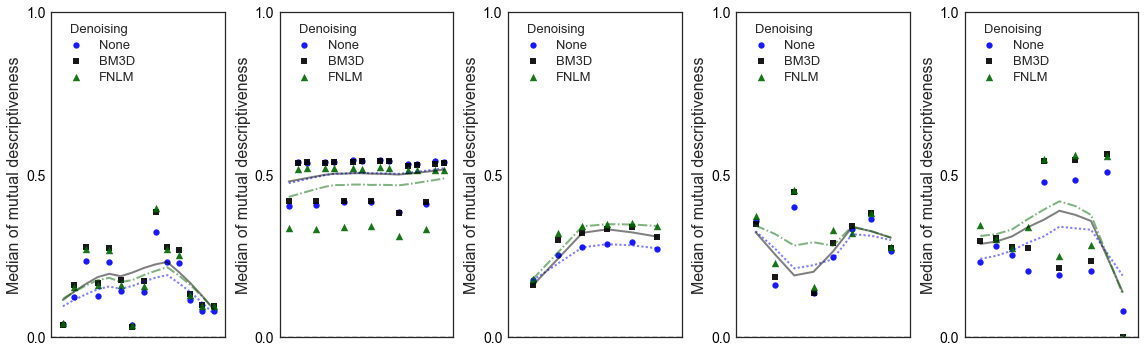

In [12]:
pid = 'cc0001'
region = 'Match points'
yrange = [0., 1.]

feature_ranks,patient_folders = pid_feature_ranking(filepath)
denoised_features = get_fixed_patient_region_features(feature_ranks, pid, region) 
patient_folder = get_patient_folder(pid, patient_folders, filepath)
min_md = sns_plot_denoise_w_feature_md(denoised_features, yrange, font_size, font_family, patient_folder, region)

In [10]:
#print('\nkruskal_dun_posthoc')
#kruskal_dun_posthoc(denoised_features)
#print('\nkruskal')
#print(kruskal(denoised_features))
#print('\nttest')
#print(ttest(denoised_features))

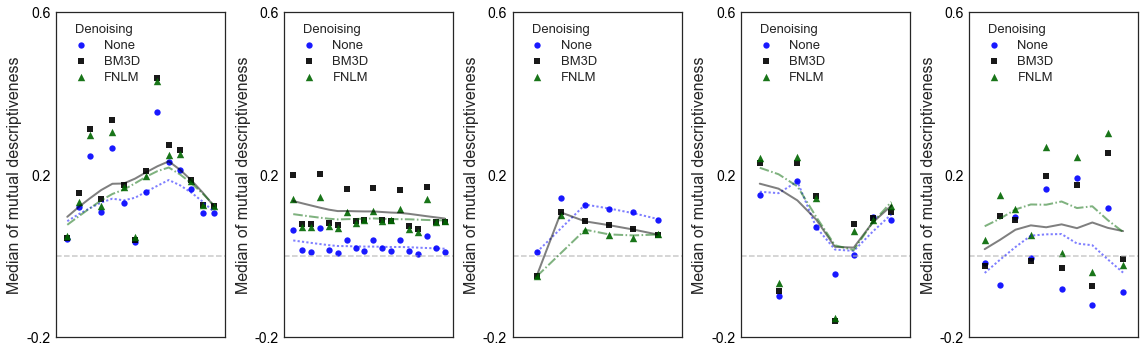

In [13]:
pid = 'cc0008'
region = 'M-H Difference'

yrange = [-.2, .6]

feature_ranks,patient_folders = pid_feature_ranking(filepath)
denoised_features = get_fixed_patient_region_features(feature_ranks, pid, region) 
patient_folder = get_patient_folder(pid, patient_folders, filepath)
min_md = sns_plot_denoise_w_feature_md(denoised_features, yrange, font_size, font_family, patient_folder, region)


In [14]:
print('\nkruskal_dun_posthoc')
kruskal_dun_posthoc(denoised_features)
#print('\nkruskal')
#print(kruskal(denoised_features))
#print('\nttest')
#print(ttest(denoised_features))


kruskal_dun_posthoc


,MIND,AG,COC,RL,CHO
H,1.5102,34.9095,0.38,2.89806,5.62573
p_omnibus,0.469963,2.62718e-08,0.826959,0.234797,0.0600327
z_pairs01,4681.14,1701.39,1012.5,1464.1,1093.5
z_pairs02,7873.14,26144.2,1352,2433.6,450.667
z_pairs12,7087.5,21632,1404.5,3534.4,240.667
p_corrected01,0,0,0,0,0
p_corrected02,0,0,0,0,0
p_corrected12,0,0,0,0,0
reject01,True,True,True,True,True
reject02,True,True,True,True,True


In [15]:
def sns_merge_plot_denoise_w_feature_md(match_denoised_features, homogenous_denoised_features, yrange = [0, 1],  font_size = 12, \
        font_family = 'Arial', patient_folder = None, region = None, feature_types = ['MIND', 'AG', 'CHO', 'COC', 'RL'],\
        denoise_methods = ['None', 'BM3D', 'FNLM']):
    
    def get_data_frame(denoise, ftype, denoised_features):
        features_md = denoised_features[denoise][ftype]
        sorted_features_md = dict((element, md) for (element, md) in sorted(features_md.items()))            
        element = list(sorted_features_md.keys())
        md = list(sorted_features_md.values())
        d = {ftype : pd.Series(element),'Mutual Descriptiveness' : pd.Series(md)}
        df = pd.DataFrame(d)
        #columns = [ftype, 'Mutual Descriptiveness']
        return df,element
    
    sns.set('paper', style="white", color_codes=True, font='Arial', font_scale = 1)
    
    font_name = {'fontname':font_family}
    gray = [0.7]*3
    colormap = [(0,0,1), (0,0,0), (0,0.4,0)]
    marker_shapes = ['o', 's', '^']
    line_styles = [':', '-', '-.']
    marker_sizes = [40,40, 55]
    
    ystep = (yrange[1]-yrange[0])/2
    ymax = yrange[1]+ystep
    ymin = yrange[0]
    
    figw, figh =12,5
    fig, axes= plt.subplots(nrows = 1, ncols = len(feature_types), sharey=True, figsize=(figw, figh))
    #plt.subplots_adjust(left=1/figw, right=1-1/figw, bottom=1/figh, top=1-1/figh)   
    
    for fidx in range(0, len(feature_types)):
        
        ax = axes[fidx]
        ftype = feature_types[fidx]
        
        ax.axhline(y=0, color=gray, linestyle='--', linewidth = 1.5, alpha = 0.7)
        
        for dn in range(0, len(denoise_methods)):
            
            denoise = denoise_methods[dn]
            
            df, element = get_data_frame(denoise, ftype, match_denoised_features) 
            xrange = [0, len(element)+1]
            ax.set(xlim=(xrange[0], xrange[1]), ylim=(yrange[0], yrange[1]))            
            
            sns.regplot(x=ftype, y="Mutual Descriptiveness", data=df, lowess  = True, order = 1,\
                        scatter_kws={"alpha":0.9,"s":marker_sizes[dn]}, \
                        line_kws={"alpha":0.4, 'linestyle':'-', 'linewidth':2},\
                        color=colormap[dn], marker = marker_shapes[dn], label=denoise, ax = ax)
            
            plt.rcParams['lines.markeredgewidth'] = 1
            df,element = get_data_frame(denoise, ftype, homogenous_denoised_features) 
            marker_kws ={"alpha":0.9,"s":marker_sizes[dn], 'facecolor':'None', 'edgecolor':colormap[dn]}
            sns.regplot(x=ftype, y="Mutual Descriptiveness", data=df, lowess  = True, order = 1,\
                        scatter_kws=marker_kws, \
                        line_kws={"alpha":0.4, 'linestyle':':', 'linewidth':2},\
                        color=colormap[dn], marker = marker_shapes[dn], label=denoise, ax = ax)     

            
        if(len(element) > 10):
            xticks = [element[i] for i in range(len(element)) if i %2 == 1 ]
        else:
            xticks = element
        ax.set_xticks(xticks)
        ax.set_xticklabels(xticks)
        ax.set_yticks(np.arange(ymin, ymax, ystep))
        ax.set_yticklabels(np.arange(ymin, ymax, ystep))
        
        if ftype == 'MIND':
            ftype = 'D-MIND'
        ax.set_xlabel('{} element numbers'.format(ftype), size = font_size+2,alpha=1.0, visible = True)
        plt.setp(ax.get_xticklabels(), visible=True)
        ax.set_ylabel("Median of mutual descriptiveness",size = font_size+2,alpha=1.0)
        plt.setp(ax.get_yticklabels(), visible=True)
        if ftype != 'D-MIND':
            ax.set_ylabel("Median of mutual descriptiveness",size = font_size,alpha=1.0, visible = False)
            plt.setp(ax.get_yticklabels(), visible=False)
        
        # Set the ticklabel size and color of the graph from here
        ax.tick_params(labelsize=14,labelcolor="black")  
        
        # legend stuff
        #legend = ax.legend(loc = 'upper left', fontsize = font_size-3, labelspacing = 0.3,\
        #            columnspacing=0.1, fancybox=True,shadow=False,title='Denoising')
        
        #for i, grp in DF_0.groupby(['color']):
        #    grp.plot(kind = 'scatter', x = 'x', y = 'y', c = i, ax = ax, label = labels[ind], zorder = 0)
        #    ind += 1       
        #ax.legend(loc=2)    
        
        
        #print('H:{}  L:{}'.format(handles, labels[1::2]))
        #print('L:{}, {}'.format(labels[1::2], labels[0::2]))
        handles, labels = ax.get_legend_handles_labels()
        legend = ax.legend(handles[0::2], labels[0::2],loc = 'upper left', fontsize = font_size-1, labelspacing = 0.4,\
                    columnspacing=0.1, fancybox=True,shadow=False,title='Match Points')       
        plt.setp(legend.get_title(),fontsize=font_size-3)

        handles, labels = ax.get_legend_handles_labels()
        legend = ax.legend(handles[1::2], labels[1::2],loc = 'upper right', fontsize = font_size-1, labelspacing = 0.4,\
                    columnspacing=0.1, fancybox=True,shadow=False,title='Denosing')       
        plt.setp(legend.get_title(),fontsize=font_size-1)        
        
        fig.subplots_adjust(hspace=0.5)     
        
        plt.tight_layout()
        
    if patient_folder:
        image_file = patient_folder+'//denoising_match_homo.png';
        fig.savefig(image_file, dpi=300, transparent=True)


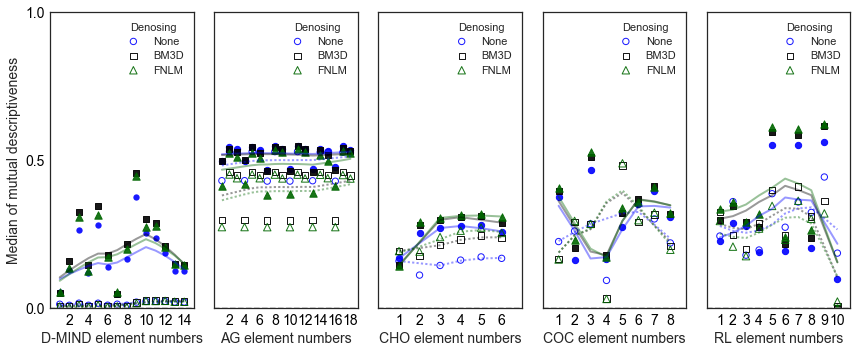

In [16]:
pid = 'cc0008'
region = 'Match points'
yrange = [0., 1.]
font_size = 12
font_family = 'Arial'

feature_ranks,patient_folders = pid_feature_ranking(filepath)
match_denoised_features = get_fixed_patient_region_features(feature_ranks, pid, region) 
#print('{}\n{}'.format(type(match_denoised_features), match_denoised_features))

region = 'Homogenous'
feature_ranks,patient_folders = pid_feature_ranking(filepath)
homogenous_denoised_features = get_fixed_patient_region_features(feature_ranks, pid, region) 
#print('\n\n{}\n{}'.format(type(homogenous_denoised_features), homogenous_denoised_features))

sns_merge_plot_denoise_w_feature_md(match_denoised_features, homogenous_denoised_features, yrange,font_size, \
        font_family, patient_folder)

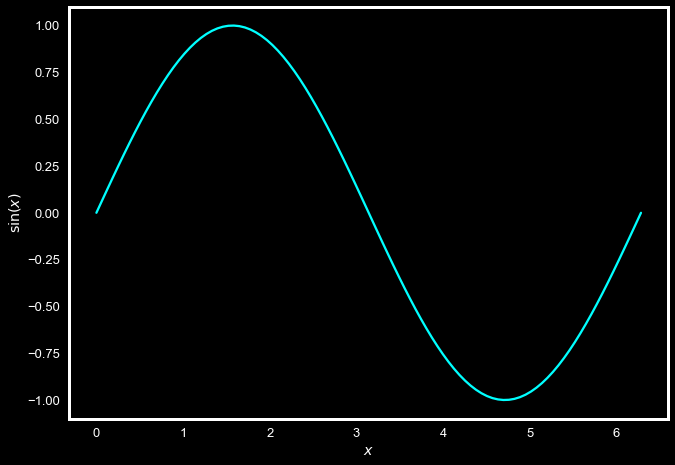

In [47]:
rc = {'axes.edgecolor': 'white', 'axes.facecolor': 'white', 'axes.labelcolor': 'white',\
      'figure.facecolor': 'white'}
sns.axes_style(style='ticks', rc=rc)

bg_color = 'black'
fg_color = 'white'

fig = plt.figure(facecolor=bg_color, edgecolor=fg_color)
axes = plt.axes((0.1, 0.1, 0.8, 0.8), facecolor=bg_color)
axes.set_frame_on(True)
#axes.patch.set_visible(False)
axes.xaxis.set_tick_params(color=fg_color, labelcolor=fg_color)
axes.yaxis.set_tick_params(color=fg_color, labelcolor=fg_color)
for spine in axes.spines.values():
    #spine.set_facecolor(fg_color)
    spine.set_edgecolor(fg_color)
    spine.set_visible(True)
    spine.set_linewidth(3)


x = np.linspace(0, 2 * np.pi, 100)
y = np.sin(x)

plt.plot(x, y, 'cyan', axes=axes)
plt.xlabel('$x$', color=fg_color)
plt.ylabel('$\sin(x)$', color=fg_color)
plt.show()

In [76]:
import matplotlib

def sns_merge_black_plot_denoise_w_feature_md(match_denoised_features, homogenous_denoised_features, yrange = [0, 1],  font_size = 12, \
        font_family = 'Arial', patient_folder = None, region = None, feature_types = ['MIND', 'AG', 'CHO', 'COC', 'RL'],\
        denoise_methods = ['None', 'BM3D', 'FNLM']):
    
    def get_data_frame(denoise, ftype, denoised_features):
        features_md = denoised_features[denoise][ftype]
        sorted_features_md = dict((element, md) for (element, md) in sorted(features_md.items()))            
        element = list(sorted_features_md.keys())
        md = list(sorted_features_md.values())
        d = {ftype : pd.Series(element),'Mutual Descriptiveness' : pd.Series(md)}
        df = pd.DataFrame(d)
        #columns = [ftype, 'Mutual Descriptiveness']
        return df,element
    
    sns.set(context="talk", style="dark", color_codes=True, font='Arial', font_scale = 1)
    rc = {'axes.edgecolor': 'white', 'axes.facecolor': 'black', 'axes.labelcolor': 'white','figure.facecolor': 'black'}
    sns.axes_style(style='dark', rc=rc)
    plt.style.use("dark_background") 
    
    font_name = {'fontname':font_family}
    gray = [0.83]*3
    colormap = [(1,0.9,0), (0,1.0,1.0), (1.0,0.7529,0.7961)]
    marker_shapes = ['o', 's', '^']
    line_styles = [':', '-', '-.']
    marker_sizes = [40,40, 55]
    
    ystep = (yrange[1]-yrange[0])/2
    ymax = yrange[1]+ystep
    ymin = yrange[0]
    
    figw, figh =12,5
    fig, axes= plt.subplots(nrows = 1, ncols = len(feature_types), sharey=True, figsize=(figw, figh))
    #plt.subplots_adjust(left=1/figw, right=1-1/figw, bottom=1/figh, top=1-1/figh)   
    
    for fidx in range(0, len(feature_types)):
        
        ax = axes[fidx]
        ftype = feature_types[fidx]
        
        ax.axhline(y=0, color=gray, linestyle='--', linewidth = 1.5, alpha = 0.7)
        
        for dn in range(0, len(denoise_methods)):
            
            denoise = denoise_methods[dn]
            
            df, element = get_data_frame(denoise, ftype, match_denoised_features) 
            xrange = [0, len(element)+1]
            ax.set(xlim=(xrange[0], xrange[1]), ylim=(yrange[0], yrange[1]))            
            
            sns.regplot(x=ftype, y="Mutual Descriptiveness", data=df, lowess  = True, order = 1,\
                        scatter_kws={"alpha":0.9,"s":marker_sizes[dn]}, \
                        line_kws={"alpha":0.7, 'linestyle':'-', 'linewidth':1.5},\
                        color=colormap[dn], marker = marker_shapes[dn], label=denoise, ax = ax)
            
            plt.rcParams['lines.markeredgewidth'] = 1
            df,element = get_data_frame(denoise, ftype, homogenous_denoised_features) 
            marker_kws ={"alpha":0.9,"s":marker_sizes[dn], 'facecolor':'None', 'edgecolor':colormap[dn]}
            sns.regplot(x=ftype, y="Mutual Descriptiveness", data=df, lowess  = True, order = 1,\
                        scatter_kws=marker_kws, \
                        line_kws={"alpha":0.7, 'linestyle':':', 'linewidth':1.5},\
                        color=colormap[dn], marker = marker_shapes[dn], label=denoise, ax = ax)     

            
        if(len(element) > 10):
            xticks = [element[i] for i in range(len(element)) if i %2 == 1 ]
        else:
            xticks = element
        ax.set_xticks(xticks)
        ax.set_xticklabels(xticks)
        ax.set_yticks(np.arange(ymin, ymax, ystep))
        ax.set_yticklabels(np.arange(ymin, ymax, ystep))
        
        if ftype == 'MIND':
            ftype = 'D-MIND'
        ax.set_xlabel('{} element numbers'.format(ftype), size = font_size+2,alpha=1.0, visible = True)
        plt.setp(ax.get_xticklabels(), visible=True)
        ax.set_ylabel("Median of mutual descriptiveness",size = font_size+2,alpha=1.0)
        plt.setp(ax.get_yticklabels(), visible=True)
        if ftype != 'D-MIND':
            ax.set_ylabel("Median of mutual descriptiveness",size = font_size,alpha=1.0, visible = False)
            plt.setp(ax.get_yticklabels(), visible=False)
        
        # Set the ticklabel size and color of the graph from here
        ax.tick_params(labelsize=14,labelcolor="white")  
        
        for spine in ax.spines.values():
            #spine.set_facecolor(fg_color)
            spine.set_edgecolor(fg_color)
            spine.set_visible(True)
            spine.set_linewidth(2)

        for child in ax.get_children():
            if isinstance(child, matplotlib.spines.Spine):
                child.set_color('white')
        # legend stuff
        #legend = ax.legend(loc = 'upper left', fontsize = font_size-3, labelspacing = 0.3,\
        #            columnspacing=0.1, fancybox=True,shadow=False,title='Denoising')
        
        #for i, grp in DF_0.groupby(['color']):
        #    grp.plot(kind = 'scatter', x = 'x', y = 'y', c = i, ax = ax, label = labels[ind], zorder = 0)
        #    ind += 1       
        #ax.legend(loc=2)    
        
        
        #print('H:{}  L:{}'.format(handles, labels[1::2]))
        #print('L:{}, {}'.format(labels[1::2], labels[0::2]))
        handles, labels = ax.get_legend_handles_labels()
        legend = ax.legend(handles[0::2], labels[0::2],loc = 'upper left', fontsize = font_size-1, labelspacing = 0.4,\
                    columnspacing=0.1, fancybox=True,shadow=False,title='Match Points')       
        plt.setp(legend.get_title(),fontsize=font_size-3)

        handles, labels = ax.get_legend_handles_labels()
        legend = ax.legend(handles[1::2], labels[1::2],loc = 'upper right', fontsize = font_size-1, labelspacing = 0.4,\
                    columnspacing=0.1, fancybox=True,shadow=False,title='Denosing')       
        plt.setp(legend.get_title(),fontsize=font_size-1)        
        
        fig.subplots_adjust(hspace=0.08, wspace=0.05)     
        
        plt.tight_layout()
        
    if patient_folder:
        image_file = patient_folder+'//denoising_match_homo_black_backgrnd.png';
        fig.savefig(image_file, dpi=300, transparent=True)


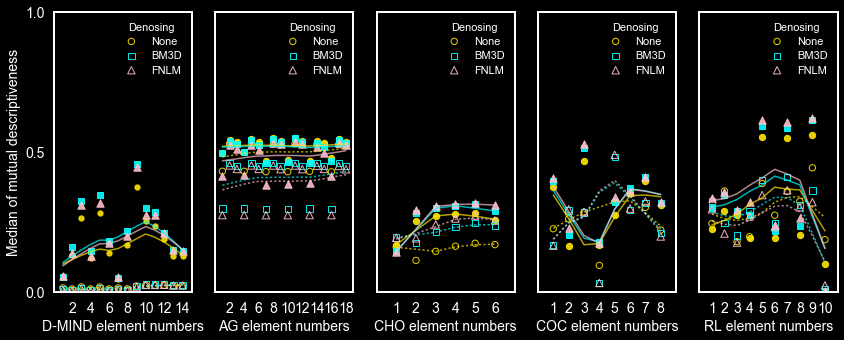

In [77]:
pid = 'cc0008'
region = 'Match points'
yrange = [0., 1.]
font_size = 12
font_family = 'Arial'

feature_ranks,patient_folders = pid_feature_ranking(filepath)
match_denoised_features = get_fixed_patient_region_features(feature_ranks, pid, region) 
#print('{}\n{}'.format(type(match_denoised_features), match_denoised_features))

region = 'Homogenous'
feature_ranks,patient_folders = pid_feature_ranking(filepath)
homogenous_denoised_features = get_fixed_patient_region_features(feature_ranks, pid, region) 
#print('\n\n{}\n{}'.format(type(homogenous_denoised_features), homogenous_denoised_features))

sns_merge_black_plot_denoise_w_feature_md(match_denoised_features, homogenous_denoised_features, yrange,font_size, \
        font_family, patient_folder)

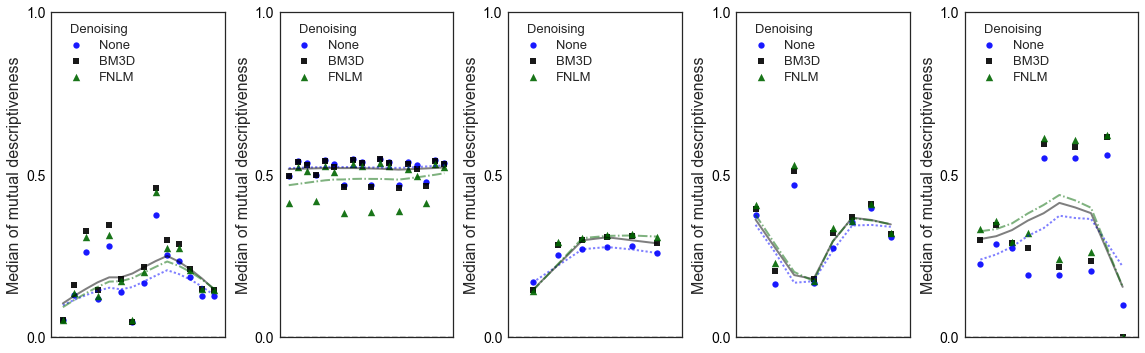

In [13]:
pid = 'cc0008'
region = 'Match points'
yrange = [0., 1.]

feature_ranks,patient_folders = pid_feature_ranking(filepath)
#print(feature_ranks['cc0008'])
denoised_features = get_fixed_patient_region_features(feature_ranks, pid, region) 
patient_folder = get_patient_folder(pid, patient_folders, filepath)
min_md = sns_plot_denoise_w_feature_md(denoised_features, yrange, font_size, font_family, patient_folder, region)

In [14]:
print('\nkruskal_dun_posthoc')
kruskal_dun_posthoc(denoised_features)
#print('\nkruskal')
#print(kruskal(denoised_features))
#print('\nttest')
#print(ttest(denoised_features))


kruskal_dun_posthoc


,MIND,AG,COC,RL,CHO
H,1.41623,8.37755,0.645,2.39226,5.47368
p_omnibus,0.492571,0.0151648,0.724336,0.302362,0.0647746
z_pairs01,4791.5,20672.2,946.125,1488.4,181.5
z_pairs02,8016.07,15664.5,1378.12,2592.1,661.5
z_pairs12,6820.07,6574.22,1458,3312.4,937.5
p_corrected01,0,0,0,0,0
p_corrected02,0,0,0,0,0
p_corrected12,0,0,0,0,0
reject01,True,True,True,True,True
reject02,True,True,True,True,True


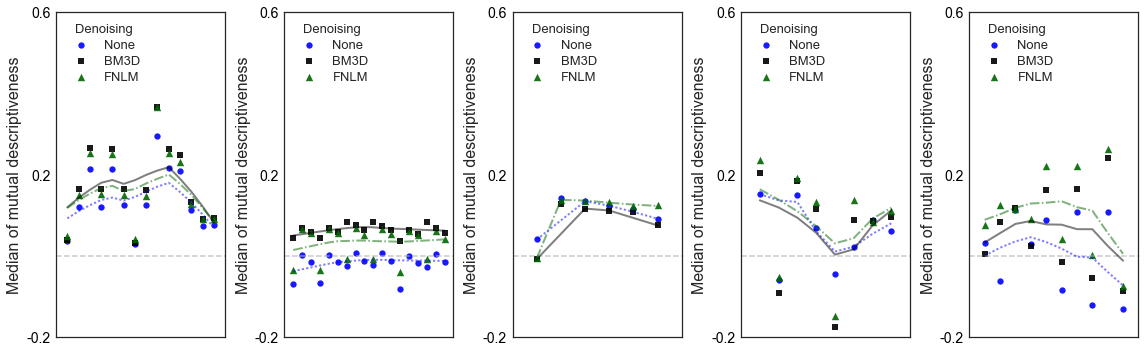

In [15]:
pid = 'cc0015'
region = 'M-H Difference'
yrange = [-.2, .6]

feature_ranks,patient_folders = pid_feature_ranking(filepath)
denoised_features = get_fixed_patient_region_features(feature_ranks, pid, region) 
patient_folder = get_patient_folder(pid, patient_folders, filepath)
min_md = sns_plot_denoise_w_feature_md(denoised_features, yrange, font_size, font_family, patient_folder, region)

In [16]:
print('\nkruskal_dun_posthoc')
kruskal_dun_posthoc(denoised_features)
#print('\nkruskal')
#print(kruskal(denoised_features))
#print('\nttest')
#print(ttest(denoised_features))


kruskal_dun_posthoc


,MIND,AG,COC,RL,CHO
H,1.85762,29.455,0.915,3.84258,3.02924
p_omnibus,0.395024,4.01725e-07,0.632864,0.146418,0.219892
z_pairs01,4536,3042,924.5,1322.5,580.167
z_pairs02,8160.29,30917.6,1275.12,2496.4,266.667
z_pairs12,6997.79,14168.1,1596.12,3686.4,864
p_corrected01,0,0,0,0,0
p_corrected02,0,0,0,0,0
p_corrected12,0,0,0,0,0
reject01,True,True,True,True,True
reject02,True,True,True,True,True


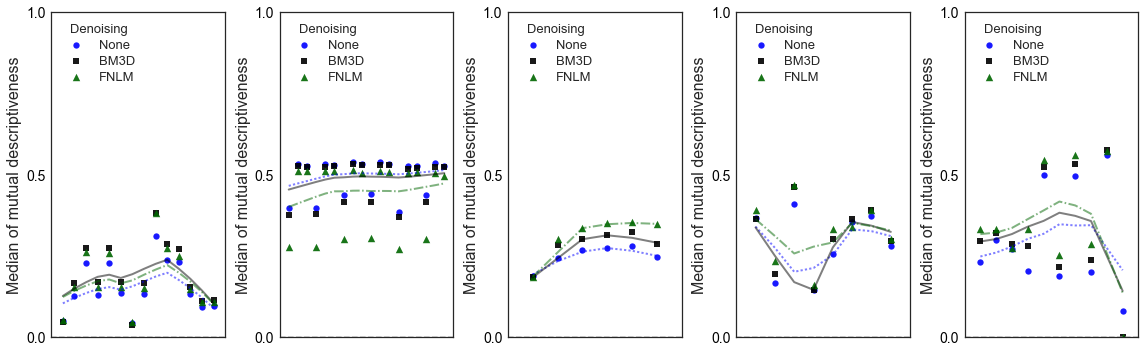

In [17]:
pid = 'cc0015'
region = 'Match points'
yrange = [0., 1.]

feature_ranks,patient_folders = pid_feature_ranking(filepath)
denoised_features = get_fixed_patient_region_features(feature_ranks, pid, region) 
patient_folder = get_patient_folder(pid, patient_folders, filepath)
min_md = sns_plot_denoise_w_feature_md(denoised_features, yrange, font_size, font_family, patient_folder, region)

In [18]:
print('\nkruskal_dun_posthoc')
#kruskal_dun_posthoc(denoised_features)
#print('\nkruskal')
#print(kruskal(denoised_features))
#print('\nttest')
#print(ttest(denoised_features))


kruskal_dun_posthoc


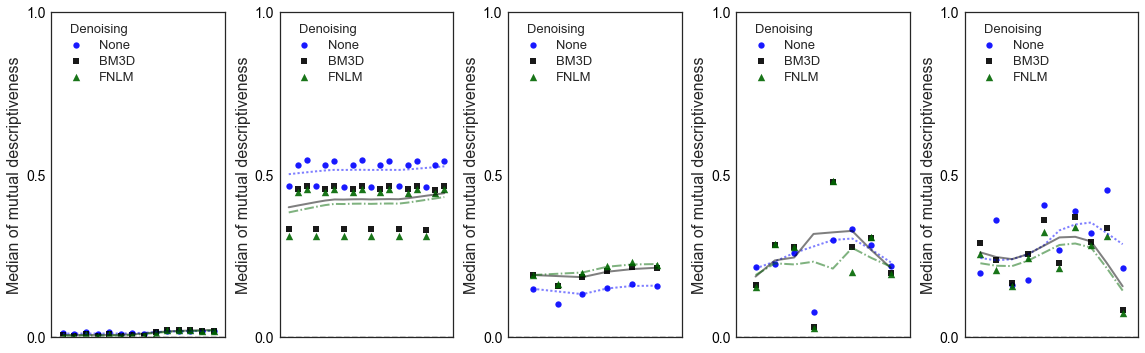

In [19]:
pid = 'cc0015'
region = 'Homogenous'

yrange = [0., 1.]

feature_ranks,patient_folders = pid_feature_ranking(filepath)
denoised_features = get_fixed_patient_region_features(feature_ranks, pid, region) 
patient_folder = get_patient_folder(pid, patient_folders, filepath)
min_md = sns_plot_denoise_w_feature_md(denoised_features, yrange, font_size, font_family, patient_folder, region)


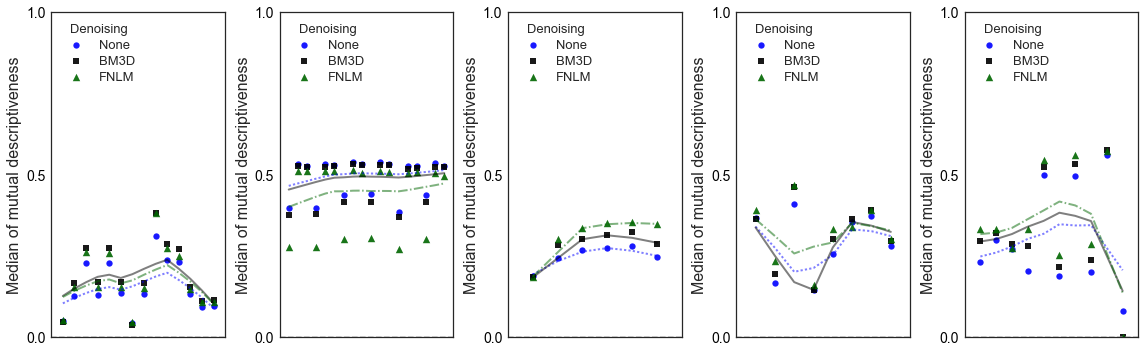

In [20]:
pid = 'cc0015'
region = 'Match points'

yrange = [0., 1.]

feature_ranks,patient_folders = pid_feature_ranking(filepath)
denoised_features = get_fixed_patient_region_features(feature_ranks, pid, region) 
patient_folder = get_patient_folder(pid, patient_folders, filepath)
min_md = sns_plot_denoise_w_feature_md(denoised_features, yrange, font_size, font_family, patient_folder, region)


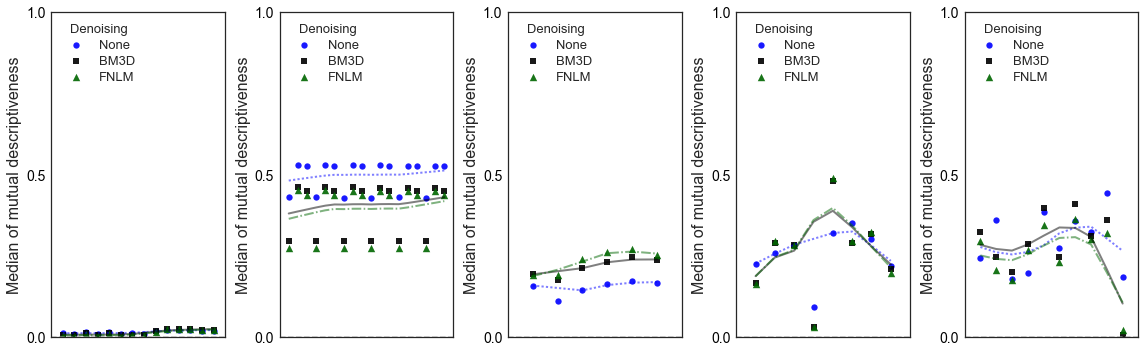

In [21]:
pid = 'cc0008'
region = 'Homogenous'

yrange = [0., 1.]

feature_ranks,patient_folders = pid_feature_ranking(filepath)
denoised_features = get_fixed_patient_region_features(feature_ranks, pid, region) 
patient_folder = get_patient_folder(pid, patient_folders, filepath)
min_md = sns_plot_denoise_w_feature_md(denoised_features, yrange, font_size, font_family, patient_folder, region)


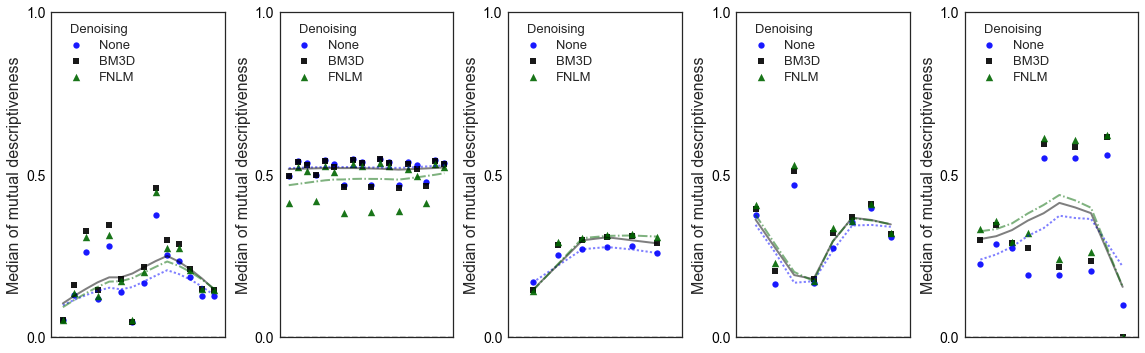

In [22]:
pid = 'cc0008'
region = 'Match points'

yrange = [0., 1.]

feature_ranks,patient_folders = pid_feature_ranking(filepath)
denoised_features = get_fixed_patient_region_features(feature_ranks, pid, region) 
patient_folder = get_patient_folder(pid, patient_folders, filepath)
min_md = sns_plot_denoise_w_feature_md(denoised_features, yrange, font_size, font_family, patient_folder, region)
